In [12]:
%matplotlib inline

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [14]:
data_dir = 'gameplay_data'
#splitfolders.ratio('./Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0)) 

In [15]:
# Налаштування пристрою
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# Повна аугментація та нормалізація на train
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Випадкове обрізання і масштабування до 224x224
        transforms.RandomHorizontalFlip(),  # Випадкове віддзеркалення по горизонталі
        transforms.RandomRotation(30),      # Випадкове обертання на ±30 градусів
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Зміна яскравості, контрасту, насиченості та відтінку
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3), # Випадкове перспективне спотворення
        transforms.ToTensor(),              # Перетворення в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормалізація
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),             # Зміна розміру зображення до 256 пікселів по меншій стороні
        transforms.CenterCrop(224),         # Вирізання центральної частини розміром 224x224
        transforms.ToTensor(),              # Перетворення в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормалізація
    ]),
}

data_dir = 'gameplay_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [17]:
# Завантаження моделі ResNet50
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Налаштування оптимізатора та функції втрат
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
# Функція навчання моделі з ранньою зупинкою
def train_model(model, criterion, optimizer, scheduler, num_epochs=8, patience=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0  # Лічильник для ранньої зупинки

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # режим тренування
            else:
                model.eval()   # режим валідації

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Перевірка для ранньої зупинки на валідаційній вибірці
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  # Скидання лічильника, якщо є покращення
                else:
                    epochs_no_improve += 1  # Збільшення лічильника, якщо покращення немає

                # Перевірка умови для ранньої зупинки
                if epochs_no_improve >= patience:
                    print("Рання зупинка: втрати не покращувалися протягом", patience, "епох")
                    model.load_state_dict(best_model_wts)
                    time_elapsed = time.time() - since
                    print(f'Навчання завершено за {time_elapsed // 60:.0f} хв {time_elapsed % 60:.0f} сек')
                    print(f'Найкраща точність на валідаційній вибірці: {best_acc:.4f}')
                    return model

            # Зберігаємо найкращу точність на валідаційній вибірці
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Навчання завершено за {time_elapsed // 60:.0f} хв {time_elapsed % 60:.0f} сек')
    print(f'Найкраща точність на валідаційній вибірці: {best_acc:.4f}')

    # Завантаження ваг для найкращої моделі
    model.load_state_dict(best_model_wts)
    return model

In [19]:
# Навчання моделі
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, patience=2)

Epoch 1/10
----------
train Loss: 1.0915 Acc: 0.6444
val Loss: 0.1959 Acc: 0.9340

Epoch 2/10
----------
train Loss: 0.6814 Acc: 0.7825
val Loss: 0.1433 Acc: 0.9575

Epoch 3/10
----------
train Loss: 0.5506 Acc: 0.8290
val Loss: 0.1131 Acc: 0.9680

Epoch 4/10
----------
train Loss: 0.4558 Acc: 0.8586
val Loss: 0.0799 Acc: 0.9740

Epoch 5/10
----------
train Loss: 0.3777 Acc: 0.8798
val Loss: 0.0924 Acc: 0.9760

Epoch 6/10
----------
train Loss: 0.3633 Acc: 0.8846
val Loss: 0.0669 Acc: 0.9795

Epoch 7/10
----------
train Loss: 0.3184 Acc: 0.8966
val Loss: 0.0631 Acc: 0.9830

Epoch 8/10
----------
train Loss: 0.2288 Acc: 0.9301
val Loss: 0.0435 Acc: 0.9875

Epoch 9/10
----------
train Loss: 0.1789 Acc: 0.9430
val Loss: 0.0351 Acc: 0.9905

Epoch 10/10
----------
train Loss: 0.1730 Acc: 0.9464
val Loss: 0.0401 Acc: 0.9890

Навчання завершено за 23 хв 50 сек
Найкраща точність на валідаційній вибірці: 0.9905


In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

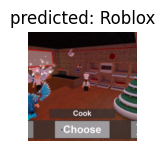

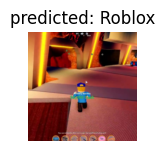

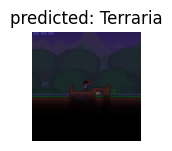

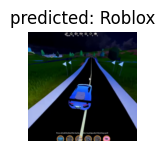

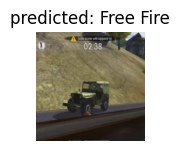

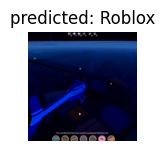

In [23]:
import numpy as np

def imshow(inp, title=None):
    """Візуалізація на Tensorflow."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # пауза для оновлення

visualize_model(model_ft)

In [24]:
torch.save(model_ft, 'games_classification_model_exp3.pth')